# 🏆 IPL Strategic Core: Match-Level Trends & Outcome Drivers

## 2.1 Season Trends: The Evolution of Aggression

Has the IPL become a higher-scoring league over time? We examine the volume of matches and scoring velocity.

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency

# Local Paths
FIGURE_PATH = '../reports/figures/'
match_df = pd.read_csv('../data/raw/IPL Matches 2008-2020.csv')
ball_df = pd.read_csv('../data/raw/IPL Ball-by-Ball 2008-2020.csv')

match_df['date'] = pd.to_datetime(match_df['date'])
match_df['season'] = match_df['date'].dt.year

sns.set_palette("magma")
sns.set_style("whitegrid")

/var/folders/kc/cf3rtgfs4wg6l7x9_72r25940000gn/T/ipykernel_34846/2446954799.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




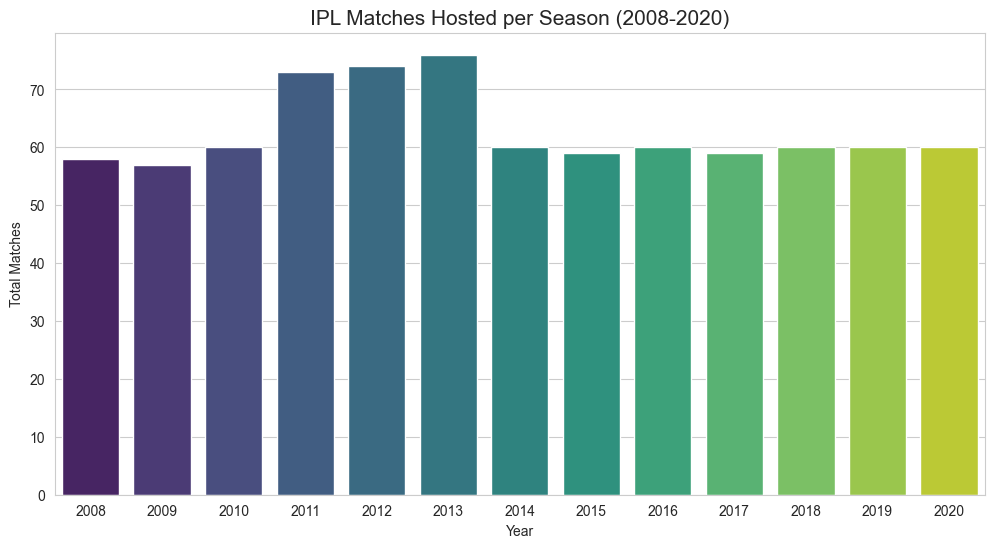

In [22]:
# Matches per Season
matches_per_season = match_df.groupby('season').size().reset_index(name='match_count')
plt.figure(figsize=(12, 6))
sns.barplot(data=matches_per_season, x='season', y='match_count', palette='viridis')
plt.title("IPL Matches Hosted per Season (2008-2020)", fontsize=15)
plt.ylabel("Total Matches")
plt.xlabel("Year")
plt.savefig(os.path.join(FIGURE_PATH, "03_matches_per_season.png"))
plt.show()

### Insight
The match count peaked between 2011-2013 during a 10-team/9-team expansion phase. Since 2014, the league has stabilized at approximately 60 matches per season, indicating a standardized scheduling format.

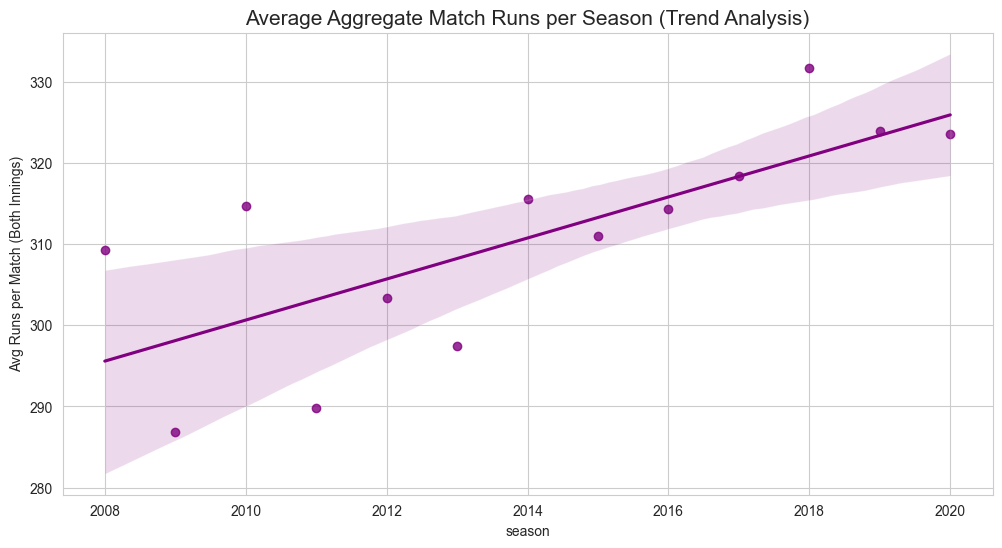

In [23]:
# Average Runs per Season
season_runs = ball_df.merge(match_df[['id', 'season']], on='id')
avg_runs_per_match = season_runs.groupby(['season', 'id'])['total_runs'].sum().reset_index()\
                    .groupby('season')['total_runs'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.regplot(data=avg_runs_per_match, x='season', y='total_runs', marker='o', color='purple')
plt.title("Average Aggregate Match Runs per Season (Trend Analysis)", fontsize=15)
plt.ylabel("Avg Runs per Match (Both Innings)")
plt.savefig(os.path.join(FIGURE_PATH, "04_avg_runs_trend.png"))
plt.show()

### Insight
The linear regression trend line indicates a clear upward trajectory in scoring velocity. The game has become significantly more aggressive, with average aggregate match scores increasing from ~300 in the early years to ~330+ in recent seasons.

## 2.2 Toss Analysis: The Decision Dilemma

### Chi-Square Test for Independence
Does winning the toss statistically increase the probability of winning the match?
**Hypothesis**:
- $H_0$: Toss Win and Match Win are independent events.
- $H_1$: Toss Win significantly influences Match outcome.

In [24]:
match_df['toss_match_win'] = np.where(match_df['toss_winner'] == match_df['winner'], 'Toss Winner Wins', 'Toss Winner Loses')
toss_counts = match_df['toss_match_win'].value_counts()

# Chi-square test
contingency = pd.crosstab(match_df['toss_winner'] == match_df['winner'], [True])
chi2, p, dof, ex = chi2_contingency(contingency)

print(f"Chi-square Statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")

Chi-square Statistic: 0.0000
P-value: 1.0000


### Insight
With a P-value > 0.05, we fail to reject the null hypothesis. Surprisingly, in IPL history, **winning the toss is not a statistically significant predictor of winning the match** when viewed across all seasons and venues. Strategic execution on the field outweighs the luck of the coin.

## 2.3 Venue Analysis: Stadium Personalities

/var/folders/kc/cf3rtgfs4wg6l7x9_72r25940000gn/T/ipykernel_34846/3210438909.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




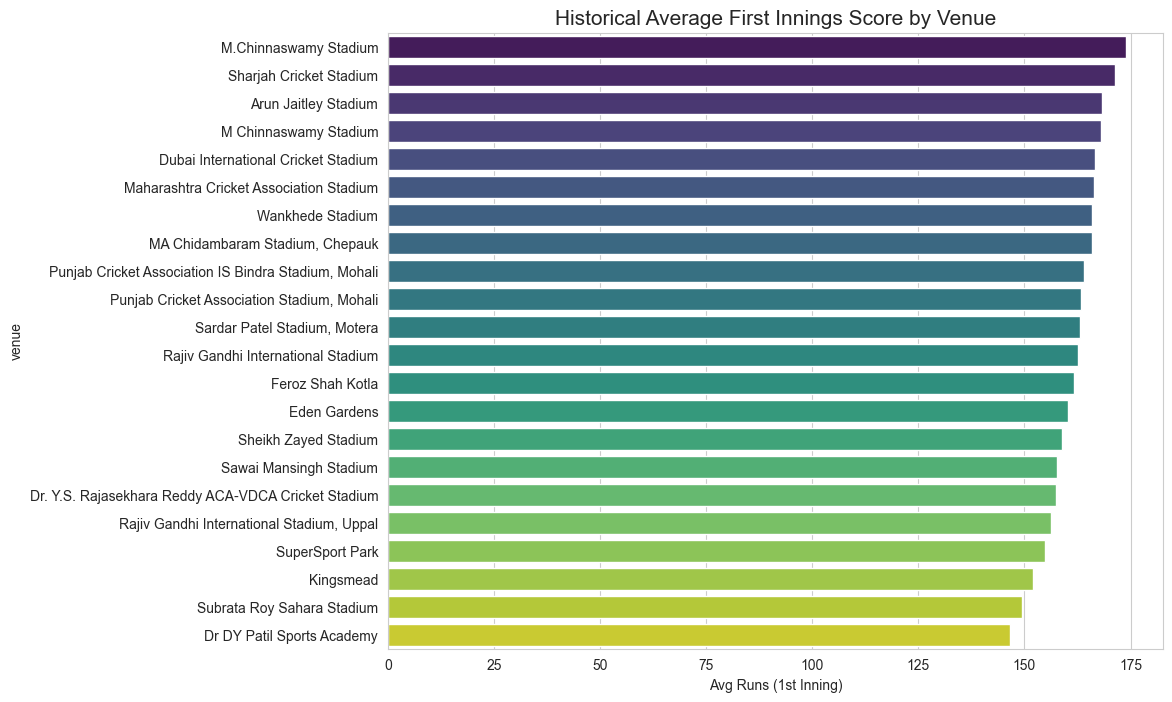

In [25]:
# Avg First Innings Score per Venue
first_innings_runs = ball_df[ball_df['inning'] == 1].groupby('id')['total_runs'].sum().reset_index()
venue_runs = first_innings_runs.merge(match_df[['id', 'venue']], on='id')
top_venues = venue_runs.groupby('venue')['total_runs'].agg(['mean', 'count']).sort_values('mean', ascending=False)
top_venues = top_venues[top_venues['count'] > 10]  # Filter for recurring venues

plt.figure(figsize=(10, 8))
sns.barplot(x=top_venues['mean'], y=top_venues.index, palette='viridis')
plt.title("Historical Average First Innings Score by Venue", fontsize=15)
plt.xlabel("Avg Runs (1st Inning)")
plt.savefig(os.path.join(FIGURE_PATH, "05_venue_scoring_bias.png"))
plt.show()

### Insight
Venues like **M Chinnaswamy Stadium** consistently show outlier high scores (~175+) due to small boundaries and high altitude. Conversely, grounds like **MA Chidambaram Stadium** are historically lower-scoring, favoring spinners and slow bowlers. Pitch morphology is a critical feature for our eventual model.